# Polynômes de chaos : application au cas de la poutre encastrée avec chaos par intégration

## Résumé

Dans ce notebook, nous présentons la décomposition en chaos polynomial du cas de la poutre encastrée. Nous montrons comment calculer les coefficients par intégration.

## Introduction

Considèrons un modèle physique $g : \mathbb{R}^p \rightarrow \mathbb{R}$ :
$$
Y = g(\boldsymbol{X})
$$
où $\boldsymbol{X} \in \mathcal{X} \subset \mathbb{R}^p$ est un vecteur aléatoire et $Y\in \mathbb{R}$ est une variable aléatoire. 
On considère la transformation $\boldsymbol{\xi} = T(\boldsymbol{X})$, où $\boldsymbol{X} \in \mathbb{R}^p$ est le vecteur aléatoire en entrée du modèle physique, $T$ est la transformation iso-probabiliste et $\boldsymbol{\xi} \in \overline{\mathcal{X}} \subset \mathbb{R}^p$ est la variable standardisée. 
On introduit la fonction $h$ définie par :
$$
h(\boldsymbol{\xi}) = g\left(T^{-1}(\boldsymbol{\xi})\right) = g \circ T^{-1} (\boldsymbol{\xi})
$$
pour tout $\boldsymbol{\xi}\in \overline{\mathcal{X}}$. 

La décomposition en polynômes du chaos est :
$$
\tilde{h}(\boldsymbol{\xi}) = \sum_{k = 0}^P a_k \Psi_k(\boldsymbol{\xi})
$$
pour tout $\boldsymbol{\xi}\in \overline{\mathcal{X}}$, où $P \in \mathbb{N}$ est le nombre de coefficients dans la décomposition, $a_k \in \mathbb{R}$ est le coefficient, $\psi_k$ est le polynôme multivarié et $\boldsymbol{\xi}$ est la variable standardisée. 

Les coefficients de la décomposition minimisent la norme euclidienne du vecteur des résidus ou, de manière équivalent, satisfont l'équation :
$$
a_k = \frac{\langle h, \Psi_k \rangle}{\|\Psi_k\|^2}
$$
pour $k = 0, ..., P$, où le produit scalaire est 
$$
\langle h, \Psi_k \rangle 
= \int_{\overline{\mathcal{X}}} h(\boldsymbol{\xi}) \Psi_k(\boldsymbol{\xi}) f_{\Xi}(\boldsymbol{\xi}) d\boldsymbol{\xi}
$$
où $f_{\boldsymbol{\Xi}}$ est la loi du vecteur aléatoire $\boldsymbol{\Xi}$ dans l'espace standard. 
Ce produit scalaire forme un espace de Hilbert sur les fonctions de carré intégrable $\mathbb{L}^2(\overline{\mathcal{X}})$. La norme qui en découle est :
$$
\|\Psi_k\|^2 
= \langle \Psi_k, \Psi_k \rangle 
= \int_{\overline{\mathcal{X}}} \Psi_k(\boldsymbol{\xi})^2 f_{\Xi}(\boldsymbol{\xi})
$$
pour $k = 0, ..., P$. De plus, les fonctions de base $\{\Psi_k\}_{k = 0, ..., P}$ sont orthonormales, alors 
$$
\|\Psi_k\| = 1
$$
ce qui implique 
$$
a_k = \langle h, \Psi_k \rangle
$$
pour $k = 0, ..., P$. 

La méthode de calcul des coefficients par intégration consiste à évaluer les intégrales associées au produit scalaire et permettant de déterminer les coefficients $\{a_k\}_{k = 0, ..., P}$. Cela représente par conséquent $P + 1$ intégrales en dimension $p$. On peut calculer une approximation de ces intégrales par des méthodes d'intégration numérique comme, par exemple, la méthode de Monte-Carlo, un plan d'expériences de type Latin Hypercube Sampling (LHS), une séquence à faible discrépance (comme par exemple la séquence de Sobol'), la quadrature de Gauss tensorisée ou encore la quadrature de Smolyak. 

Dans l'exemple ci-dessous, nous utilisons la quadrature de Gauss tensorisée. 

In [1]:
import openturns as ot
import openturns.viewer as otv

In [2]:
dist_E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250.0, 260.0)  # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310.0, 450.0)  # in cm^4
dist_I.setDescription(["I"])

myDistribution = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

dim_input = 4  # dimension of the input
dim_output = 1  # dimension of the output


def function_beam(X):
    E, F, L, I = X
    Y = F * (L ** 3) / (3 * E * I)
    return [Y]


g = ot.PythonFunction(dim_input, dim_output, function_beam)
g.setInputDescription(myDistribution.getDescription())

## Créer le polynôme

On crée la base polynomiale multivariée par tensorisation de polynômes univariés avec la règle d'énumération linéaire par défaut.

In [3]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [dist_E, dist_F, dist_L, dist_I]
)

Nous devons une règle de troncature : ici, nous avons choisit la `FixedStrategy`, ce qui revient à conserver les `P` premiers polynômes de la base de polynômes. Dans notre cas particulier, nous avons déterminé `P` en utilisant la méthode  `getStrataCumulatedCardinal`, de telle sorte que c'est l'ensemble des polynômes multivariés de degré total inférieur ou égal à 5 qui est conservé. 

In [4]:
totalDegree = 5
enumerateFunction = multivariateBasis.getEnumerateFunction()
strataIndex = enumerateFunction.getMaximumDegreeStrataIndex(totalDegree)
maximumBasisSize = enumerateFunction.getStrataCumulatedCardinal(strataIndex)
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, maximumBasisSize)
adaptiveStrategy

class=FixedStrategy derived from class=AdaptiveStrategyImplementation maximumDimension=126

On observe que le nombre de polynômes correspondant à notre règle de troncature est égal à 126.

Nous définissons maintenant la règle de calcul des coefficients ; nous choisissons la méthode par intégration. Les coefficients sont estimés dans l'espace standard, associé au variables $\boldsymbol{\xi} = T(\boldsymbol{X})$, où $\boldsymbol{X} \in \mathbb{R}^p$ est le vecteur aléatoire en entrée du modèle physique, $T$ est la transformation iso-probabiliste t $\boldsymbol{\xi}$ est la variable standardisée. Cette transformation iso-probabiliste permet, parmi d'autres avantages, d'utiliser la famille des polynômes orthogonaux classiques. C'est pourquoi la méthode d'intégration doit générer des noeuds dans l'espace standard des $\boldsymbol{\xi}$. 

On commence par obtenir la mesure standard associée à la base polynomiale multivariée. On observe que l'intervalle de définition de la loi `Beta` est standardisée entre -1 et 1. Il en est de même pour la loi `Uniform` et la seconde loi `Beta`.

In [5]:
distributionStandard = multivariateBasis.getMeasure()
distributionStandard

class=ComposedDistribution name=ComposedDistribution dimension=4 copula=class=IndependentCopula name=IndependentCopula dimension=4 marginal[0]=class=Beta name=Beta dimension=1 alpha=0.9 beta=2.2 a=-1 b=1 marginal[1]=class=LogNormal name=LogNormal dimension=1 muLog=9.46206 sigmaLog=0.554513 gamma=0 marginal[2]=class=Uniform name=Uniform dimension=1 a=-1 b=1 marginal[3]=class=Beta name=Beta dimension=1 alpha=2.5 beta=1.5 a=-1 b=1

In [6]:
marginalSize = [4] * dim_input
experiment = ot.GaussProductExperiment(distributionStandard, marginalSize)

On peut observer la taille du plan d'expériences associé.

In [7]:
experiment.generate().getSize()

256

On observe que la règle de quadrature est associée à un plan d'expériences de taille 256.

In [8]:
projectionStrategy = ot.IntegrationStrategy(experiment)

On peut maintenant créer le chaos fonctionnel. 

In [9]:
chaosalgo = ot.FunctionalChaosAlgorithm(
    g, myDistribution, adaptiveStrategy, projectionStrategy
)
chaosalgo.run()

Get the result


In [10]:
result = chaosalgo.getResult()

La méthode `getMetaModel` retourne une fonction permettant d'évaluer le métamodèle.

In [11]:
metamodel = result.getMetaModel()

## Validate the metamodel

Generate a validation sample (which is independent of the training sample).

In [12]:
n_valid = 1000
inputTest = myDistribution.getSample(n_valid)
outputTest = g(inputTest)

La classe `MetaModelValidation` permet de valider le métamodèle sur une base de validation.

In [13]:
val = ot.MetaModelValidation(inputTest, outputTest, metamodel)

Compute the $Q^2$ predictivity coefficient

In [14]:
Q2 = val.computePredictivityFactor()[0]
Q2

0.9999575691056145

Plot the observed versus the predicted outputs.

/home/devel/miniconda3/envs/otsupgalilee/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/devel/miniconda3/envs/otsupgalilee/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


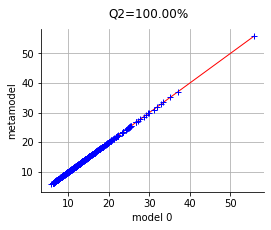

In [15]:
graph = val.drawValidation()
graph.setTitle("Q2=%.2f%%" % (Q2 * 100))
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que les coefficients sont relativement bien estimés puisque le Q2 est excellent (parfait ?), malgré un nombre de points relativement réduit dans le plan d'expériences (256 points).

## Exercice 1 : changer de méthode de quadrature

Dans cet exercice, on souhaite expérimenter d'autres méthodes de quadrature. Dans OpenTURNS, la classe `WeightedExperiment` est la classe mère pour tous les plans d'expériences appropriés pour approcher une intégrale multi-dimensionnelle. Ces méthodes de quadrature sont :
$$
\int_{\overline{\mathcal{X}}} \overline{h}(\boldsymbol{\xi}) f_{\boldsymbol{\Xi}} (\boldsymbol{\xi}) d\boldsymbol{\xi}
\approx \sum_{j = 1}^n w^{(j)} \overline{h}(\boldsymbol{\xi}^{(j)})
$$
où $\overline{h}$ est l'intégrande et $f_{\boldsymbol{\Xi}}$ est la densité de probabilité du vecteur aléatoire $\boldsymbol{\Xi}$. 

Pour utiliser ces classes, on peut évaluer la méthode  `generateWithWeights`, qui a la séquence d'appel suivante :
```
nodes, weights = experiment.generateWithWeights()
```
où `nodes` est un `Sample` représentant les noeuds de la quadrature et `weights` est un `Point` représentant les poids de la quadrature. Pour utiliser la méthode de quadrature, on évalue l'intégrande et on réalise le produit scalaire avec le vecteur des poids :
```
g_values = g_function(nodes).asPoint()
approximate_integral = g_values.dot(weights)
```
Puisque ces plans d'expériences sont associés à une densité de probabilité, leur constructeur nécessite une `Distribution` en entrée de la classe. 

En conséquence, toutes ses classes dérivées sont éligibles pour estimer les coefficients du chaos polynomial, comme par exemple la classe `MonteCarloExperiment`. 

_Questions_

- Utiliser la classe `MonteCarloExperiment` pour estimer les coefficients du chaos polynomial par Monte-Carlo simple. Pour cela, utiliser un échantillon d'apprentissage de taille $n = 1000$. Calculer le score de prédictivité $Q^2$ avec un échantillon de test. Quels sont les avantages et inconvénients de cette méthode ? 
- Répéter l'expérience précédente avec la classe `LHSExperiment`. A quel point les résultats sont-ils modifiés ?
- Utiliser la classe `LowDiscrepancyExperiment` pour estimer les coefficients du chaos polynomial par une séquence à faible discrépance. Pour cela, utiliser la séquence de Sobol' avec la classe `SobolSequence`. Quelle taille d'échantillon $n$ permet d'obtenir un résultat comparable au résultat de la classe `MonteCarloExperiment` en termes de score Q2 ?

## Exercice 2 : position des noeuds d'une méthode de quadrature

Le but de cet exercice est d'observer les noeuds d'une méthode de quadrature.

_Questions_

- Utiliser la méthode `DrawPairs` pour dessiner les projections bidimensionnelles d'un plan de type `MonteCarloExperiment` associé à la distribution `distributionStandard` avec 50 points. Qu'observez-vous ?
- Faire la même expérience avec un plan de type `LHSExperiment` et `LowDiscrepancyExperiment`. 
- Enfin, observez les points d'un plan de type `GaussProductExperiment`. Qu'observez-vous ?